# Project Objectives and Context:

**Objectives**:
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence).

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also analyze and interpret a model for biases across key demographic groups. 

### Dataset:

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008).

### Data Schema:


# Data Evaluation and Preparation:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp

from sklearn.metrics import brier_score_loss, accuracy_score, f1_score 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split

import aequitas as ae
import functools

# my functions
import functions as fun

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
import pickle

# RELOAD FUNCTIONS

In [2]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

In [3]:
# OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
df = pd.read_csv('./data/final_project_dataset.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [6]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
other_diagnosis_codes       object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
ndc_code                    object
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
dtype: object

In [7]:
df.shape

(143424, 26)

## Level of EHR Data

It is important to establish whether the dataset is at the line or encounter level. The key fields for this are encounter_id and patient_nbr. Knowing this information will help inform what level of aggregation is necessary for future steps. 

This is commonly overlooked with EHR data.

In [8]:
df.encounter_id.nunique()

101766

In [9]:
df.encounter_id.value_counts()

63415968     6
63184686     6
58316058     6
60016020     6
110310714    6
            ..
59620986     1
11112060     1
94477950     1
103436358    1
396736952    1
Name: encounter_id, Length: 101766, dtype: int64

In [10]:
df.patient_nbr.nunique()

71518

Line level EHR data is the most granular level.  It is a denormalized representation of all things that may happen in a patient encounter.
- For example, could be one row for a new medication, one row for a new diagnosis or a row for a procedure or lab test.

Understanding levels and aggregating EHR data is so important for analysis and modeling!  There may be multiple rows that can be condensed into one patient or one encounter and without understanding this, the data could have a lot of unnecessary noise and create unwanted errors and biases.

In [11]:
fun.test_level(df)

Dataset is probably at the line level.


The encounter_id count is less than the total rows of the dataset, which means that the data is at line level. 
- This means that there may be a lot of missing/null values because one row is not representative of the entire encounter/visit.
- Aggregation will most definitely be needed!

I would like to take a quick look at the unique encounter_id values as well as the unique patient_nbr values so I have an idea of what types of aggregation will be needed.

In [12]:
encounters = df['encounter_id']
encounter_dups = df[encounters.isin(encounters[encounters.duplicated()])]
print(encounter_dups.shape)
encounter_dups.head()

(72680, 26)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO
7,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,35208-001,None,None,Ch,NO
8,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,16729-001,None,None,Ch,NO
9,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,47918-891,None,None,Ch,NO


I will probably aggregate this EHR data on either the encounter_id or patient_nbr features. Grouping by primary diagnosis is also an option.  I will need to explore further before deciding.

In [13]:
patients = df['patient_nbr']
patient_dups = df[patients.isin(patients[patients.duplicated()])]
print(patient_dups.shape)
patient_dups.head()

(105643, 26)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO
7,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,35208-001,None,None,Ch,NO
8,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,16729-001,None,None,Ch,NO
9,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,47918-891,None,None,Ch,NO


## Feature Analysis:

To start my analysis into the features of this dataset, I will go ahead and distinguish between the categorical columns and the numerical columns.

In [14]:
cat_cols = df.select_dtypes(include=['O'])
num_cols = df.select_dtypes(exclude=['O'])
print(f'The categorical columns are: \n{list(cat_cols.columns)}\n')
print(f'The numeric columns are: \n{list(num_cols.columns)}')

The categorical columns are: 
['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code', 'max_glu_serum', 'A1Cresult', 'change', 'readmitted']

The numeric columns are: 
['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'number_outpatient', 'number_inpatient', 'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']


### Null and Placeholder Values:

Check for null values.

In [15]:
fun.missing_data(df)

,Total,Percent
ndc_code,23462,16.35849


The NDC Code feature is the only column with missing values.

In [16]:
df_placeholders, df_cardinality = fun.get_null_get_cardinality(df, cat_cols)

In [17]:
df_placeholders

,columns,placeholder,total_placeholders
0,race,?,3309
1,gender,Unknown/Invalid,5
2,age,,0
3,weight,?,139122
4,payer_code,?,54190
5,medical_specialty,?,69463
6,primary_diagnosis_code,?,33
7,other_diagnosis_codes,?|?,340
8,ndc_code,,0
9,max_glu_serum,None,136409


Observations:

- Weight = Most of this column is missing!
- A1 test and glucose test have a lot of 'None' values.
    - Note:  Because this is at line level it may be possible that they are only recorded once in an encounter, however this is a very high number of placeholders.

### Cardinality in Categorical Features:

I can check for high cardinality in the categorical features with the loop above.

In [18]:
df_cardinality

,columns,total_unique,unique_values
0,race,6,"[Caucasian, AfricanAmerican, ?, Other, Asian, ..."
1,gender,3,"[Female, Male, Unknown/Invalid]"
2,age,10,"[[0-10), [10-20), [20-30), [30-40), [40-50), [..."
3,weight,10,"[?, [75-100), [50-75), [0-25), [100-125), [25-..."
4,payer_code,18,"[?, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, CH..."
5,medical_specialty,73,"[Pediatrics-Endocrinology, ?, InternalMedicine..."
6,primary_diagnosis_code,717,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434,..."
7,other_diagnosis_codes,19374,"[?|?, 250.01|255, 250|V27, 250.43|403, 157|250..."
8,ndc_code,252,"[nan, 68071-1701, 0378-1110, 0049-4110, 47918-..."
9,max_glu_serum,4,"[None, >300, Norm, >200]"


In [19]:
df_cardinality[df_cardinality.total_unique > 20]

,columns,total_unique,unique_values
5,medical_specialty,73,"[Pediatrics-Endocrinology, ?, InternalMedicine..."
6,primary_diagnosis_code,717,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434,..."
7,other_diagnosis_codes,19374,"[?|?, 250.01|255, 250|V27, 250.43|403, 157|250..."
8,ndc_code,252,"[nan, 68071-1701, 0378-1110, 0049-4110, 47918-..."


Observations of features with high cardinality (>20 unique values):

- medical_specialty (73) - various medical providers (specializing in large number of different fields)
    - Many overlap in speciality.
- primary_diagnosis_code (717) - there is a wide variety of primary diagnoses
- Other diagnosis codes cardinality is **very** high.  
    - From the values shown it seems to be a combined diagnosis column (maybe 2nd and 3rd diagnoses).    
- ndc_code (252) - There is a wide variety of codes for similiar medications. 
    - I will discuss in more detail later, but each non-generic name gets a unique code as well as the different dosages of each medication.


These features having high cardinality is not a surprise and just adds more evidence to the importance of understanding the data!

### Numerical Feature Distributions:

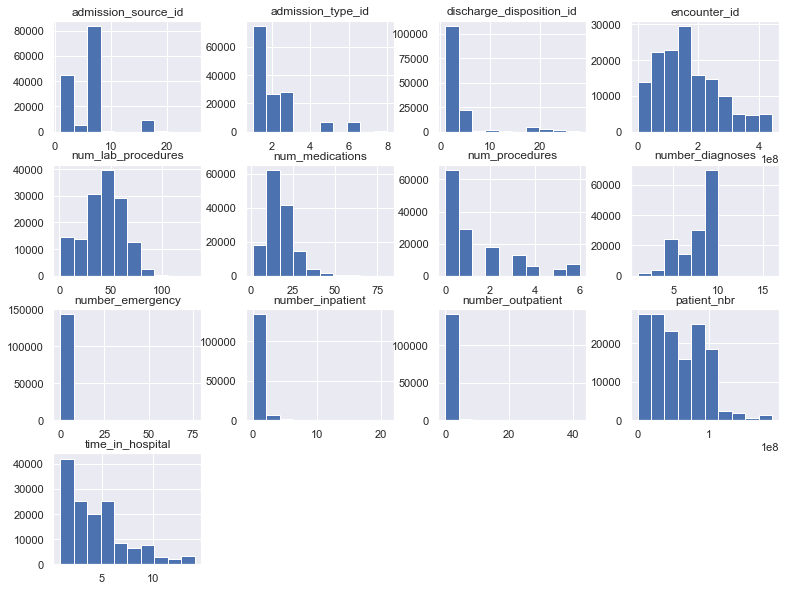

In [20]:
df.hist(figsize=(13,10))
plt.show()

In [21]:
# for col in df.columns:
#     if col in num_cols:
#         plt.hist(df[col])
#         plt.title(col)
#         plt.show()

After evaluating frequency histograms of the numerical columns, it is worth noting that the categories num_lab_procedures and num_medications seem to follow a normal distribution.

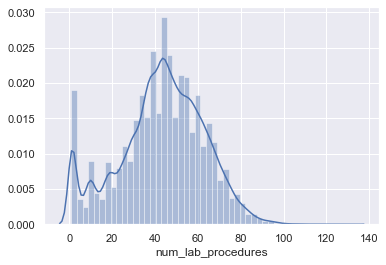

In [22]:
sns.distplot(df.num_lab_procedures)
plt.show()

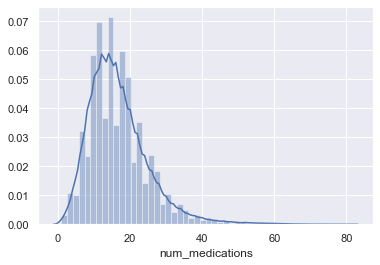

In [23]:
sns.distplot(df.num_medications)
plt.show()

### Patient Demographic Feature Distributions:

The age feature is bucketed into 10 year groups.

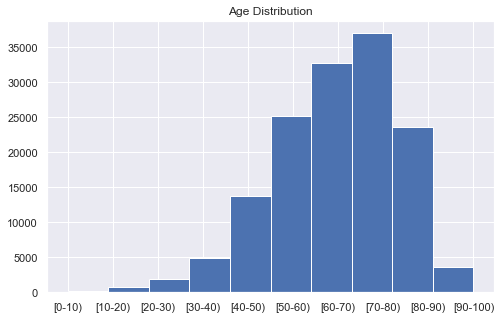

In [24]:
df.age.hist(figsize=(8, 5))
plt.title('Age Distribution')
plt.show()

The gender feature has female and male values with a couple unknown values.

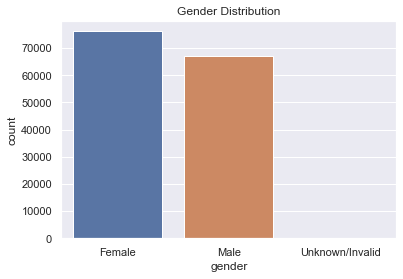

In [25]:
sns.countplot(x="gender", data=df)
plt.title('Gender Distribution')
plt.show()

Observations:

There are more female patients than male as shown in the gender distribution, but not by much.  I believe this is an insignificant difference.
- This lines with my assumption that females are generally more likely to seek medical help than males.
    
The 50-90 age range is highly represented in this dataset.
- This makes sense with my assumption that younger patients tend to be "more healthy" than older aged patients.

## NDC Codes: 

NDC codes are a common format to represent the wide variety of drugs that are prescribed in the United States. The challenge is that there are many codes that map to the same or similar drug. 
- There are crosswalk connections made to assist with this.  They are mappings to connect different code sets or datasets depending on the data being used.
- The National Drug Codes List site: (https://ndclist.com/)
    - Using the NDC lookup tool I will reduce the dimensionality of the NDC code feature.

In [26]:
ndc_code_df = pd.read_csv('ndc_crosswalk')
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [27]:
# ndc_code_df.to_csv('ndc_crosswalk.csv', index=False)

To reduce dimensionality:  
- Join the two datasets on the NDC code columns.  
- Only need the Non-proprietary name column from the NDC data.
    - This is the generic name for the drug.
    - This will reduce dimensionality because there are similiar drugs prescribed to the diabetic patients, but many non-generic names for the same drug **AND** different dosage forms for each drug.
        - Each of these different dosages or non-generic name, etc equate to it's own unique NDC code.

The importance of understanding these differences (or lack there of), is crucial because, like the diagnosis and encounter data, you could end up with a lot of noise or unnecessary data.

In [28]:
df_original = df.copy()

In [29]:
df = fun.reduce_ndc(df_original, ndc_code_df)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide


In [30]:
# df.to_csv('reduce_dim_df.csv', index=False)

To check that the reduction worked:

- The number of unique values for the new columns should be less than the original columns.


In [31]:
orig_codes = df_original['ndc_code'].nunique() 
reduced_codes = df['generic_drug'].nunique()
print(f'Reduced from {orig_codes} to {reduced_codes}')

df_original['ndc_code'].nunique() > df['generic_drug'].nunique()

Reduced from 251 to 22


True

## Patient Encounters:

To simplify the aggregation of data further, I will pull the first encounter for each unique patient in the dataset. 
- This is to reduce the risk of data leakage of future patient encounters.
    - Data leakage in EHR data is when patient data is shared across the training and test datasets.  It leads to inaccurate labels and demographics that are not reflective of the real world during modeling.
- This will reduce complexity of the data transformation during modeling steps.

I can pull the first encounter by numerically sorting the encounter_id column and group on the patient_nbr column.

In [32]:
encounter_df = df.sort_values(['encounter_id'], 
                              ascending=True).groupby('patient_nbr').head(1)
encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug
12,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,Insulin Human
14,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide
15,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,Human Insulin
6,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,Insulin Human


To test this:  
- The number of unique patients from our original line level dataset should be equal to:
    - the new output of unique encounters 
    - the new output of unique patients

In [33]:
unique_patients = encounter_df['patient_nbr'].nunique()
print(f'Unique patients: {unique_patients}')

unique_encounters = encounter_df['encounter_id'].nunique()
print(f'Unique encounters: {unique_encounters}')

original_patient_count = df['patient_nbr'].nunique()
print(f'Unique patients: {original_patient_count}')

Unique patients: 71518
Unique encounters: 71518
Unique patients: 71518


In [34]:
encounter_df.change.replace({'Ch': 'Yes'}, inplace=True)
encounter_df.change.value_counts(normalize=True)

encounter_df['readmitted_binary'] = encounter_df['readmitted']
encounter_df.readmitted_binary.replace({'>30': 'Yes', '<30': 'Yes'}, 
                                       inplace=True)
encounter_df['readmitted_binary'].value_counts(normalize=True)

second_list = []
third_list = []
for val in encounter_df['other_diagnosis_codes']:
    second_list.append(val.split('|')[0])
    third_list.append(val.split('|')[1])
    
encounter_df['second_diagnosis_code'] = second_list
encounter_df['other_diagnosis_code'] = third_list

encounter_df.drop(['other_diagnosis_codes'], axis=1, inplace=True)

encounter_df.loc[encounter_df['gender']=='Unknown/Invalid']
encounter_df.drop([40924, 105884, 116206], axis=0, inplace=True)

In [35]:
# encounter_df.to_csv('encounter_level.csv', index=False)

In [36]:
# diab_dict = pickle.load(open("diag_codes.pkl", "rb"))

In [37]:
# df_dict = pd.DataFrame(list(diab_dict.items()),columns = ['diag_code','diagnosis'])

In [38]:
# df_dict.to_csv('diagnosis_codes.csv', index=False)

In [39]:
encounter_df = pd.read_csv('primary_diag_labeled.csv')
encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name,readmitted_binary,second_diagnosis_code,other_diagnosis_code
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,circulatory,0,0,0,68,8,28,2,None,None,Yes,NO,Insulin Human,NO,427.0,38.0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,circulatory,0,0,0,33,8,18,3,None,None,Yes,NO,Human Insulin,NO,198.0,486.0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,neoplasms,0,0,0,51,5,8,0,None,None,Yes,NO,Glipizide,NO,157.0,250.0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,diabetes,0,0,0,47,9,17,2,None,None,No,>30,Human Insulin,Yes,403.0,996.0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,circulatory,0,0,0,31,9,16,6,None,None,No,>30,Insulin Human,Yes,411.0,250.0


## Aggregate for Modeling:

To ensure that the data is on the correct EHR data level, we need to aggregate columns and build the dataset at the appropriate level.

I will transform the dataset using the 'generic_drug' feature.  Then create dummy columns for each unique generic drug name as added engineered features. 

In [40]:
# list columns to use for grouping
groups = [col for col in encounter_df.columns if col != 'generic_drug_name']

In [41]:
agg_df, agg_drug_cols = fun.aggregate_dataset(df=encounter_df, group_list=groups,
                                         array_field='generic_drug_name')

In [42]:
agg_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,second_diagnosis_code,other_diagnosis_code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,circulatory,0,0,0,68,8,28,2,None,None,Yes,NO,NO,427.0,38.0,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,circulatory,0,0,0,33,8,18,3,None,None,Yes,NO,NO,198.0,486.0,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,neoplasms,0,0,0,51,5,8,0,None,None,Yes,NO,NO,157.0,250.0,[Glipizide],0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,diabetes,0,0,0,47,9,17,2,None,None,No,>30,Yes,403.0,996.0,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,circulatory,0,0,0,31,9,16,6,None,None,No,>30,Yes,411.0,250.0,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
agg_drug_cols

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

To test the aggregation:

- The row count should be the same as the unique patient and the unique encounter.

In [44]:
len(agg_df) == agg_df['patient_nbr'].nunique() == agg_df['encounter_id'].nunique()

True

In [45]:
agg_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,second_diagnosis_code,other_diagnosis_code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,circulatory,0,0,0,68,8,28,2,None,None,Yes,NO,NO,427.0,38.00,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,circulatory,0,0,0,33,8,18,3,None,None,Yes,NO,NO,198.0,486.00,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,neoplasms,0,0,0,51,5,8,0,None,None,Yes,NO,NO,157.0,250.00,[Glipizide],0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,diabetes,0,0,0,47,9,17,2,None,None,No,>30,Yes,403.0,996.00,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,circulatory,0,0,0,31,9,16,6,None,None,No,>30,Yes,411.0,250.00,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71510,443842016,183087545,Caucasian,Female,[70-80),?,1,1,7,9,?,?,digestive,0,0,0,50,9,33,2,None,>7,Yes,>30,Yes,574.0,250.02,[Glyburide],0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71511,443842022,188574944,Other,Female,[40-50),?,1,1,7,14,MD,?,genitourinary,0,0,1,73,9,26,6,None,>8,Yes,>30,Yes,599.0,518.00,[Glipizide],0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71512,443842070,140199494,Other,Female,[60-70),?,1,1,7,2,MD,?,injury,1,1,1,46,9,17,6,None,None,No,>30,Yes,585.0,403.00,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71513,443842340,120975314,Caucasian,Female,[80-90),?,1,1,7,5,MC,?,MentalDisorders,0,0,1,76,9,22,1,None,None,Yes,NO,NO,8.0,304.00,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Selection and Preprocessing:

### Feature Selection

For feature selection:

- Look again at numerical column distributions.
- Evaluate percentage of values across columns.

Create seperate lists for chosen categorical and numeric features for subsets.

In [46]:
agg_df.number_diagnoses.value_counts(normalize=True)

9     0.443809
5     0.125009
6     0.107544
7     0.106397
8     0.105712
4     0.062406
3     0.033056
2     0.012319
1     0.002699
16    0.000433
13    0.000140
10    0.000126
15    0.000098
12    0.000098
11    0.000084
14    0.000070
Name: number_diagnoses, dtype: float64

In [47]:
num_cols = encounter_df.select_dtypes(exclude='O')
cat_cols = encounter_df.select_dtypes(include='O')

In [48]:
# cat_cols

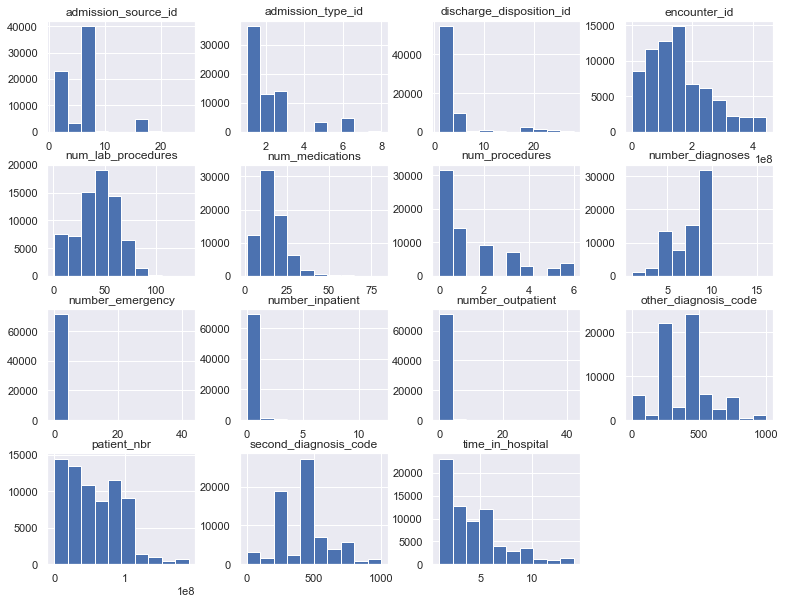

In [49]:
num_cols.hist(figsize = (13, 10))
plt.show()

In [50]:
agg_df.time_in_hospital.value_counts(normalize=True)

3     0.177599
2     0.173348
1     0.149829
4     0.133776
5     0.095630
6     0.072307
7     0.055918
8     0.040803
9     0.027826
10    0.021786
11    0.017353
12    0.013354
13    0.011117
14    0.009355
Name: time_in_hospital, dtype: float64

In [51]:
agg_df.readmitted.value_counts(normalize=True)

NO     0.601021
>30    0.310984
<30    0.087996
Name: readmitted, dtype: float64

I am going to clone the readmitted column and then update the values to a simple 'Yes' or 'No' response for whether the patient was readmitted or not.  Currently it is split into 'No' and then <30 days or <30 days for a readmission.

In [52]:
agg_df['readmitted_binary'] = agg_df['readmitted']
agg_df.readmitted_binary.replace({'>30': 1, '<30': 1, 'NO':0}, inplace=True)
agg_df['readmitted_binary'].value_counts(normalize=True)

0    0.601021
1    0.398979
Name: readmitted_binary, dtype: float64

In [53]:
agg_df.change.value_counts(normalize=True)

No     0.552234
Yes    0.447766
Name: change, dtype: float64

In [54]:
# agg_df.change.replace({'Ch': 'Yes'}, inplace=True)
# agg_df.change.value_counts(normalize=True)

In [55]:
agg_df.max_glu_serum.value_counts(normalize=True)

None    0.951674
Norm    0.024205
>200    0.013550
>300    0.010571
Name: max_glu_serum, dtype: float64

In [56]:
agg_df.A1Cresult.value_counts(normalize=True)

None    0.818416
>8      0.088149
Norm    0.053010
>7      0.040425
Name: A1Cresult, dtype: float64

In [57]:
agg_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,second_diagnosis_code,other_diagnosis_code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,circulatory,0,0,0,68,8,28,2,None,None,Yes,NO,0,427.0,38.0,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,circulatory,0,0,0,33,8,18,3,None,None,Yes,NO,0,198.0,486.0,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,neoplasms,0,0,0,51,5,8,0,None,None,Yes,NO,0,157.0,250.0,[Glipizide],0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,diabetes,0,0,0,47,9,17,2,None,None,No,>30,1,403.0,996.0,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,circulatory,0,0,0,31,9,16,6,None,None,No,>30,1,411.0,250.0,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
agg_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'number_outpatient', 'number_inpatient',
       'number_emergency', 'num_lab_procedures', 'number_diagnoses',
       'num_medications', 'num_procedures', 'max_glu_serum', 'A1Cresult',
       'change', 'readmitted', 'readmitted_binary', 'second_diagnosis_code',
       'other_diagnosis_code', 'generic_drug_name_array', 'Acarbose',
       'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 

I have decided on the following features for modeling:

In [59]:
num_feats = ['num_lab_procedures', 'num_medications', 'time_in_hospital',
            'number_diagnoses']
cat_feats = ['race', 'gender', 'age', 'primary_diagnosis_code', 
                        'change'] + agg_drug_cols
TARGET = 'readmitted_binary'

In [60]:
feats_df = fun.select_features(agg_df, cat_feats, num_feats, TARGET)
feats_df

,patient_nbr,readmitted_binary,race,gender,age,primary_diagnosis_code,change,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses
0,48330783,0,Caucasian,Female,[80-90),circulatory,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,28,13,8
1,63555939,0,Caucasian,Female,[90-100),circulatory,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,18,12,8
2,42519267,0,Caucasian,Male,[40-50),neoplasms,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51,8,1,5
3,89869032,1,AfricanAmerican,Female,[40-50),diabetes,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,17,9,9
4,82637451,1,Caucasian,Male,[50-60),circulatory,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,16,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71510,183087545,1,Caucasian,Female,[70-80),digestive,Yes,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,33,9,9
71511,188574944,1,Other,Female,[40-50),genitourinary,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73,26,14,9
71512,140199494,1,Other,Female,[60-70),injury,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,17,2,9
71513,120975314,0,Caucasian,Female,[80-90),MentalDisorders,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76,22,5,9


In [61]:
feats_df.dtypes

patient_nbr                                     int64
readmitted_binary                               int64
race                                           object
gender                                         object
age                                            object
primary_diagnosis_code                         object
change                                         object
Acarbose                                      float64
Glimepiride                                   float64
Glipizide                                     float64
Glipizide_And_Metformin_Hcl                   float64
Glipizide_And_Metformin_Hydrochloride         float64
Glyburide                                     float64
Glyburide_And_Metformin_Hydrochloride         float64
Glyburide-metformin_Hydrochloride             float64
Human_Insulin                                 float64
Insulin_Human                                 float64
Metformin_Hcl                                 float64
Metformin_Hydrochloride     

### Preprocessing - Casting:

In [62]:
def update_dtypes(df, categorical_col_list, predictor):
    df[predictor] = df[predictor].astype(float)
    for col in categorical_col_list:
        df[col] = df[col].astype('str')
    return df

In [63]:
processed_df = update_dtypes(feats_df, cat_feats, TARGET)

In [64]:
processed_df.head()

,patient_nbr,readmitted_binary,race,gender,age,primary_diagnosis_code,change,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses
0,48330783,0.0,Caucasian,Female,[80-90),circulatory,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,28,13,8
1,63555939,0.0,Caucasian,Female,[90-100),circulatory,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,18,12,8
2,42519267,0.0,Caucasian,Male,[40-50),neoplasms,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51,8,1,5
3,89869032,1.0,AfricanAmerican,Female,[40-50),diabetes,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,17,9,9
4,82637451,1.0,Caucasian,Male,[50-60),circulatory,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,16,3,9


In [65]:
processed_df.dtypes

patient_nbr                                     int64
readmitted_binary                             float64
race                                           object
gender                                         object
age                                            object
primary_diagnosis_code                         object
change                                         object
Acarbose                                       object
Glimepiride                                    object
Glipizide                                      object
Glipizide_And_Metformin_Hcl                    object
Glipizide_And_Metformin_Hydrochloride          object
Glyburide                                      object
Glyburide_And_Metformin_Hydrochloride          object
Glyburide-metformin_Hydrochloride              object
Human_Insulin                                  object
Insulin_Human                                  object
Metformin_Hcl                                  object
Metformin_Hydrochloride     

In [66]:
# processed_df.to_csv('processed.csv', index=False)

## Train, Validation, and Test Splits:

For a deep learning model, the data needs to be split into three subsets.

- The validation set = used for optimizing the model's hyperparameters during training 
- 60%/20%/20% train/validation/test split
- Randomly sample different patients from each split.

**IMPORTANT** Make sure that a patient's data is not in more than one set!
   - Avoid possible data leakage

In [67]:
processed_df.shape

(71515, 31)

In [68]:
train, test = train_test_split(processed_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

45769 train examples
11443 validation examples
14303 test examples


In [69]:
len(train) + len(val) + len(test) == len(processed_df)
# print("Test passed for number of total rows equal!")

True

In [70]:
(train['patient_nbr'].nunique() + val['patient_nbr'].nunique() + test['patient_nbr'].nunique()) == agg_df['patient_nbr'].nunique()
# print("Test passed for number of unique patients being equal!")

True

In [71]:
# train_df, val_df, test_df = fun.train_test_val_split(processed_df, 'patient_nbr')

In [72]:
# print(len(train_df), 'train examples')
# print(len(val_df), 'validation examples')
# print(len(test_df), 'test examples')

To test against accidental patient data leakage:
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset.
- Total number of rows in original dataset = sum of rows across all three splits.

In [73]:
# test_split = len(train_df) + len(val_df) + len(test_df) == len(processed_df)
# if test_split==True:
#     print('Split equal rows test passed!')
# else: print('Test not passed!')

In [74]:
# test_split2 = (train_df['patient_nbr'].nunique() 
#                + val_df['patient_nbr'].nunique() 
#         + test_df['patient_nbr'].nunique()) == agg_df['patient_nbr'].nunique()
# if test_split2==True:
#     print("Split unique patients test passed!")
# else: print('Test not passed!')

## Feature Representation Across Splits:

After splitting EHR data, it's wise to check the distribution of features and demographics to ensure that the groups are represented appropriately across the train, test and validations splits. 

I created a visualization function that shows how these groups are distributed.

### Target Distribution:

I will evaluate the distributution of the label across the splits. I am looking for similiar distribution shapes across partitions.

Data before splits: 

readmitted_binary
0.0    42982
1.0    28533
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


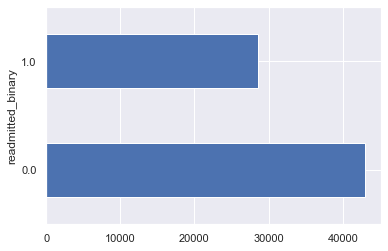

In [75]:
print('Data before splits: \n')
fun.demo_plots(processed_df, TARGET)

Training data: 

readmitted_binary
0.0    27475
1.0    18294
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


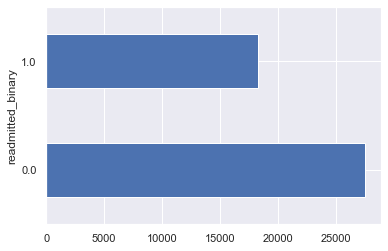

In [76]:
print('Training data: \n')
fun.demo_plots(train, TARGET)

Testing data: 

readmitted_binary
0.0    8602
1.0    5701
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


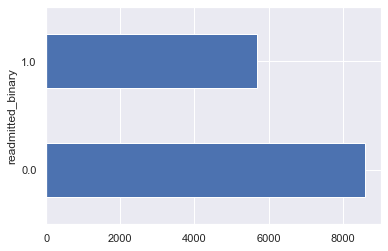

In [77]:
print('Testing data: \n')
fun.demo_plots(test, TARGET)

### Patient Demographic Distributions:

I will check that my splits are similar in terms of the patient demographic representations. 

I can use the same function as above to visualize and analyze the full dataset vs. the splits.

Data before splits: 

gender
Female    38025
Male      33490
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


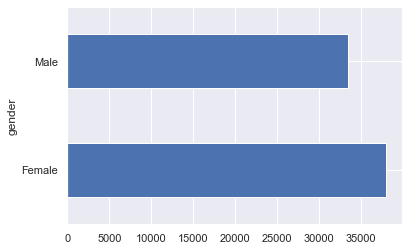

In [78]:
pt_demo_feats = ['race', 'gender', 'age', 'patient_nbr']
pt_demo_df = processed_df[pt_demo_feats].groupby('patient_nbr').head(1)
pt_demo_df.reset_index(drop=True, inplace=True)

print('Data before splits: \n')
fun.demo_plots(pt_demo_df, 'gender')

Data before splits: 

age
[0-10)        154
[10-20)       535
[20-30)      1127
[30-40)      2699
[40-50)      6878
[50-60)     12466
[60-70)     15959
[70-80)     18208
[80-90)     11589
[90-100)     1900
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


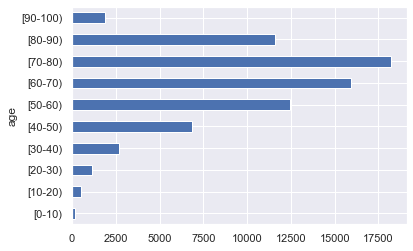

In [79]:
print('Data before splits: \n')
fun.demo_plots(pt_demo_df, 'age')

Training split: 

gender
Female    24409
Male      21360
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


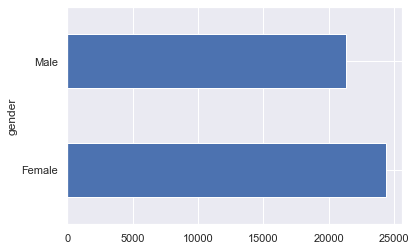

In [80]:
print('Training split: \n')
fun.demo_plots(train, 'gender')

Training split: 

age
[0-10)         98
[10-20)       352
[20-30)       721
[30-40)      1721
[40-50)      4439
[50-60)      7997
[60-70)     10164
[70-80)     11696
[80-90)      7388
[90-100)     1193
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


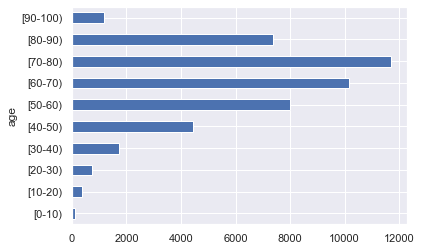

In [81]:
print('Training split: \n')
fun.demo_plots(train, 'age')

Training split: 

gender
Female    7529
Male      6774
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


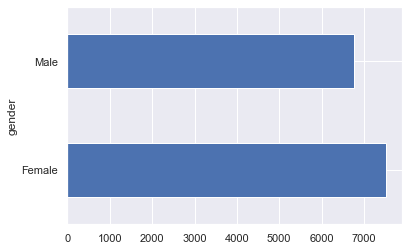

In [82]:
print('Training split: \n')
fun.demo_plots(test, 'gender')

Training split: 

age
[0-10)        36
[10-20)      112
[20-30)      217
[30-40)      540
[40-50)     1365
[50-60)     2548
[60-70)     3191
[70-80)     3639
[80-90)     2273
[90-100)     382
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


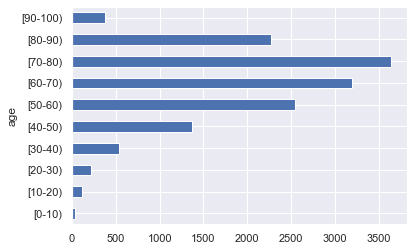

In [83]:
print('Training split: \n')
fun.demo_plots(test, 'age')

Great!  These look pretty similiar and should be representative of all patient groups and data.

## Convert to Tensorflow Dataset:

Now it is time to start converting my dataset splits into Tensorflow datasets!

To execute this conversion, I used boilerplate code that I referenced from Tensorflow's tutorial documentation.

https://www.tensorflow.org/tutorials/structured_data/feature_columns


In [84]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
train_ds = fun.df_to_dataset(train, TARGET, batch_size=batch_size)
val_ds = fun.df_to_dataset(val, TARGET, batch_size=batch_size)
test_ds = fun.df_to_dataset(test, TARGET, batch_size=batch_size)

In [85]:
# Convert dataset from Pandas dataframes to TF dataset 
# batch_size = 128
# diabetes_train_ds = fun.df_to_dataset(train_df, TARGET, batch_size=batch_size)
# diabetes_val_ds = fun.df_to_dataset(val_df, TARGET, batch_size=batch_size)
# diabetes_test_ds = fun.df_to_dataset(test_df, TARGET, batch_size=batch_size)

In [86]:
# sample for visualizing transformations
samp_batch = next(iter(train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))
    
# def show_transformations(feature_column, example_batch):
#     """
#     This function takes in a Tensorflow feature and sample batch from
#     the original Tensorflow training dataset.
#     It returns the feature layer transformations 
#     from the sample batch.
#     """
#     feature_layer = tf.keras.layers.DenseFeatures(feature_column)
#     print(feature_layer(example_batch))
#     return feature_layer(example_batch)

# TF Categorical Features:

I will use Tensorflow's Feature Columns API to create my categorical features for modeling.

## Vocabulary Lists:

To create TF categorical features, I first will need to build vocab files that will contain the unique values for each feature. 
- This should be from the **training** split.

In [87]:
train.columns

Index(['patient_nbr', 'readmitted_binary', 'race', 'gender', 'age',
       'primary_diagnosis_code', 'change', 'Acarbose', 'Glimepiride',
       'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide',
       'num_lab_procedures', 'num_medications', 'time_in_hospital',
       'number_diagnoses'],
      dtype='object')

In [88]:
categorical_features = [ 'race', 'gender', 'age',
       'primary_diagnosis_code', 'change', 'Acarbose', 'Glimepiride',
       'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide']

numerical_features = ['num_lab_procedures', 'num_medications', 'time_in_hospital',
       'number_diagnoses']

In [89]:
cats_vocab_list = fun.build_vocab_list(train, cat_feats)
cats_vocab_list

['./diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/primary_diagnosis_code_vocab.txt',
 './diabetes_vocab/change_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Human_Insulin_vocab.txt',
 './diabetes_vocab/Insulin_Human_vocab.txt',
 './diabetes_vocab/Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Miglitol_vocab.txt',
 './diabetes_vocab/Nateglinide_vocab.txt',
 './diabetes_vocab/Pioglitazone_vocab.txt',
 './diabetes_vocab/Pioglitazone_Hydrochloride_And_Glime

## Feature Columns API - Categorical:

Using the vocab file list I created above, I can now create the Tensorflow categorical features.

This function used was adapted from the Tensorflow Feature Column API documentation.

https://www.tensorflow.org/api_docs/python/tf/feature_column.

In [90]:
tf_categorical_list = fun.create_tf_cat_feature(cat_feats)

INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 20 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in Glimepiride is inferred from the number of elements in the vocabulary

In [91]:
test_cat_feat1 = tf_categorical_list[0]
print(f'Test categorical field:\n \n{test_cat_feat1}')
fun.show_transformations(test_cat_feat1, samp_batch)

Test categorical field:
 
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='race', vocabulary_file='./diabetes_vocab/race_vocab.txt', vocabulary_size=7, num_oov_buckets=1, dtype=tf.string, default_value=-1))
tf.Tensor(
[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]], shape=(128, 8), dtype=float32)


<tf.Tensor: shape=(128, 8), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)>

# TF Numerical Features:

Again, using the TF Feature Column API, I can now create normalized Tensorflow numeric features for modeling. 

- z-score normalizer function  
- 'calculate_stats_from_train_data' function.

(https://www.tensorflow.org/api_docs/python/tf/feature_column/)

In [92]:
tf_numerical_list = fun.create_tf_numerical_feat_columns(num_feats, train)

### num_lab_procedures: #mean/std: 43.0022941292141/19.972080428928912, numeric (normalized)
### num_medications: #mean/std: 15.64864864864865/8.269992961341563, numeric (normalized)
### time_in_hospital: #mean/std: 4.272171120190522/2.9362158458082317, numeric (normalized)
### number_diagnoses: #mean/std: 7.243461731739824/1.9965016266073268, numeric (normalized)


In [93]:
tf_numerical_list

[NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numericals at 0x7fadc1d36dd0>, mean=43.0022941292141, std=19.972080428928912)),
 NumericColumn(key='num_medications', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numericals at 0x7fadc1d36dd0>, mean=15.64864864864865, std=8.269992961341563)),
 NumericColumn(key='time_in_hospital', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numericals at 0x7fadc1d36dd0>, mean=4.272171120190522, std=2.9362158458082317)),
 NumericColumn(key='number_diagnoses', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numericals at 0x7fadc1d36dd0>, mean=7.243461731739824, std=1.9965016266073268))]

In [94]:
test_num_var1 = tf_numerical_list[0]
print(f'Example normalized, numerical field:\n\n{test_num_var1}\n')
fun.show_transformations(test_num_var1, samp_batch)

Example normalized, numerical field:

NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numericals at 0x7fadc1d36dd0>, mean=43.0022941292141, std=19.972080428928912))

tf.Tensor(
[[-0.21052632]
 [-0.10526316]
 [-1.4736842 ]
 [-1.3157895 ]
 [-1.3684211 ]
 [ 0.        ]
 [-0.10526316]
 [-1.5263158 ]
 [-0.57894737]
 [-0.2631579 ]
 [-1.5789474 ]
 [-0.7368421 ]
 [ 0.47368422]
 [ 1.        ]
 [ 0.47368422]
 [-1.8947369 ]
 [ 1.5789474 ]
 [-2.1578948 ]
 [-0.42105263]
 [ 1.5263158 ]
 [ 0.36842105]
 [-0.94736844]
 [ 0.10526316]
 [ 0.2631579 ]
 [ 0.57894737]
 [-0.2631579 ]
 [ 0.31578946]
 [-0.2631579 ]
 [ 1.1052631 ]
 [-1.1578947 ]
 [-1.3157895 ]
 [ 0.94736844]
 [ 0.        ]
 [ 1.2631578 ]
 [-0.21052632]
 [ 1.3157895 ]
 [ 1.1578947 ]
 [ 0.10526316]
 [-1.5789474 ]
 [-0.84210527]
 [ 0.2631579 ]
 [-0.94736844]
 [ 0.57894737]
 [ 1.5789474 ]
 [ 0.10526316]
 [-0.21052632]
 [ 1.2631578 ]
 [ 0.6315789 ]
 [ 1.1052

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[-0.21052632],
       [-0.10526316],
       [-1.4736842 ],
       [-1.3157895 ],
       [-1.3684211 ],
       [ 0.        ],
       [-0.10526316],
       [-1.5263158 ],
       [-0.57894737],
       [-0.2631579 ],
       [-1.5789474 ],
       [-0.7368421 ],
       [ 0.47368422],
       [ 1.        ],
       [ 0.47368422],
       [-1.8947369 ],
       [ 1.5789474 ],
       [-2.1578948 ],
       [-0.42105263],
       [ 1.5263158 ],
       [ 0.36842105],
       [-0.94736844],
       [ 0.10526316],
       [ 0.2631579 ],
       [ 0.57894737],
       [-0.2631579 ],
       [ 0.31578946],
       [-0.2631579 ],
       [ 1.1052631 ],
       [-1.1578947 ],
       [-1.3157895 ],
       [ 0.94736844],
       [ 0.        ],
       [ 1.2631578 ],
       [-0.21052632],
       [ 1.3157895 ],
       [ 1.1578947 ],
       [ 0.10526316],
       [-1.5789474 ],
       [-0.84210527],
       [ 0.2631579 ],
       [-0.94736844],
       [ 0.57894737],
    

# Deep Learning Regression Model:

With Sequential API and TF Probability Layers:

## Combine Features using DenseFeatures:

So far I have prepared the categorical and numerical features using Tensorflow's Feature Column API., 
Now I need to combine them into a dense vector representation. 

In [95]:
# tf_categorical_list

In [96]:
TARGET

'readmitted_binary'

In [97]:
combined_feature_cols = tf_categorical_list + tf_numerical_list
combined_feature_layer = tf.keras.layers.DenseFeatures(combined_feature_cols)

## Sequential API Model from DenseFeatures and TF Probability Layers

Boilerplate code a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers.


- Adapted from Tensorflow Probability Regression tutorial:

https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb    


In [98]:
# # The `lambda:` creates a callable object with no arguments.
# batch_size = len(train)
# train_ds_call = lambda: fun.df_to_dataset(train, TARGET, batch_size=batch_size)
# val_ds_call = lambda: fun.df_to_dataset(val, TARGET, batch_size=batch_size)
# test_ds_call = lambda: fun.df_to_dataset(test, TARGET, batch_size=batch_size)

In [99]:
# from IPython.display import clear_output

In [100]:
# linear_est = tf.estimator.LinearClassifier(combined_feature_cols)

# # Train model.
# linear_est.train(train_ds_call, max_steps=100)

# # Evaluation.
# result = linear_est.evaluate(test_ds_call)
# clear_output()
# print(pd.Series(result))

In [101]:
# # Since data fits into memory, use entire dataset per layer. It will be faster.
# # Above one batch is defined as the entire dataset.
# n_batches = 2
# est = tf.estimator.BoostedTreesClassifier(combined_feature_cols,
#                                           n_batches_per_layer=n_batches)

# # The model will stop training once the specified number of trees is built, not
# # based on the number of steps.
# est.train(train_ds_call, max_steps=100)

# # Eval.
# result = est.evaluate(test_ds_call)
# clear_output()
# print(pd.Series(result))

In [102]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

EPOCHS = 100
BATCH_SIZE = 2048

def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Flatten(input_shape=(4,)),
        tf.keras.layers.Dense(16, activation=tf.nn.relu),
        tf.keras.layers.Dense(16, activation=tf.nn.relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
    return model

def build_model(train_dataset, val_dataset, feature_layer, epochs=5, 
                loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(
        optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', 
                                verbose=1,
                                patience=10,
                                mode='max',
                                restore_best_weights=True)     
    history = model.fit(train_dataset, validation_data=val_dataset,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [103]:
diabetes_model, history = build_model(train_ds, val_ds, 
                                          combined_feature_layer,  
                                                    epochs=50)

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
355/358 [============================>.] - ETA: 0s - loss: 0.6730 - tp: 602.1493 - fp: 832.2338 - tn: 12814.9944 - fn: 8534.6225 - accuracy: 0.5761 - precision: 0.4186 - recall: 0.1220 - auc: 0.5502WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'patient_nbr': <tf.Tensor 'ExpandDims_26:0' shape=(None, 1) dtype=int64>, 'race': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=string>, 'gender': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=string>, 'age': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=string>, 'primary_diagnosis_code': <tf.Tensor 'ExpandDims_27:0' shape=(None, 1) dtype=string>, 'change': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=string>, 'Acarbose': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=string>, 'Glimepiride': <tf.Tensor 'ExpandDims_1:0' shape=

Epoch 2/50
358/358 [==============================] - 2s 6ms/step - loss: 0.6605 - tp: 894.0418 - fp: 848.3928 - tn: 12970.4095 - fn: 8326.4930 - accuracy: 0.6021 - precision: 0.5150 - recall: 0.1047 - auc: 0.5920 - val_loss: 0.6588 - val_tp: 288.0000 - val_fp: 274.0000 - val_tn: 6631.0000 - val_fn: 4250.0000 - val_accuracy: 0.6046 - val_precision: 0.5125 - val_recall: 0.0635 - val_auc: 0.5919
Epoch 3/50
358/358 [==============================] - 2s 5ms/step - loss: 0.6577 - tp: 1192.3231 - fp: 1126.9109 - tn: 12699.5933 - fn: 8020.5097 - accuracy: 0.6033 - precision: 0.5175 - recall: 0.1362 - auc: 0.6007 - val_loss: 0.6584 - val_tp: 1136.0000 - val_fp: 1117.0000 - val_tn: 5788.0000 - val_fn: 3402.0000 - val_accuracy: 0.6051 - val_precision: 0.5042 - val_recall: 0.2503 - val_auc: 0.5965
Epoch 4/50
358/358 [==============================] - 2s 5ms/step - loss: 0.6563 - tp: 1581.8524 - fp: 1465.4123 - tn: 12348.6880 - fn: 7643.3844 - accuracy: 0.6067 - precision: 0.5215 - recall: 0.1767 

## Uncertainty Range:

Let's look at the predictions.

In [104]:
feature_list = cat_feats + num_feats
diabetes_x_tst = dict(test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(test_ds)

43459    Caucasian
42906    Caucasian
8777     Caucasian
6281         Asian
           ...    
2999      Hispanic
39305    Caucasian
65221    Caucasian
30411    Caucasian
4394     Caucasian
Name: race, Length: 14303, dtype: object, 'gender': 40187    Female
43459      Male
42906      Male
8777     Female
6281       Male
          ...  
2999       Male
39305    Female
65221    Female
30411      Male
4394     Female
Name: gender, Length: 14303, dtype: object, 'age': 40187    [90-100)
43459     [60-70)
42906     [50-60)
8777      [60-70)
6281      [60-70)
           ...   
2999      [30-40)
39305     [70-80)
65221     [80-90)
30411     [80-90)
4394      [70-80)
Name: age, Length: 14303, dtype: object, 'primary_diagnosis_code': 40187          neoplasms
43459        respiratory
42906        respiratory
8777         circulatory
6281           digestive
              ...       
2999            diabetes
39305          digestive
65221    musculoskeletal
30411             injury
4394         cir

In [105]:
metrics = diabetes_model.evaluate(test_ds)
print("Metrics", metrics)

112/112 [==============================] - 1s 4ms/step - loss: 0.6565 - tp: 1362.0000 - fp: 1351.0000 - tn: 7251.0000 - fn: 4339.0000 - accuracy: 0.6022 - precision: 0.5020 - recall: 0.2389 - auc: 0.6010
Metrics [0.6565224528312683, 1362.0, 1351.0, 7251.0, 4339.0, 0.6021813750267029, 0.5020272731781006, 0.23890545964241028, 0.6009589433670044]


## Show Prediction Output 

In [106]:
# test_ds.columns

In [107]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": test[TARGET].values,
#     "pred_mean": pred_mean.numpy().flatten(),
#     "pred_std": pred_std.numpy().flatten()
}
prob_df = pd.DataFrame(prob_outputs)

In [108]:
prob_df.head()

,pred,actual_value
0,0.556094,0.0
1,0.164002,1.0
2,0.348219,1.0
3,0.357653,0.0
4,0.526595,1.0


Using the binary lablels array, I can make in a dataframe to better visualize. 
The Aequitas toolkit requires a dataframe as well.
- Predictions will be mapped to a binary label 
- predictions = score
- actual = label_value

In [109]:
predictions_test_df = fun.add_predictions(test, preds, 
                                          ['race', 'gender'], TARGET)                                

In [110]:
predictions_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 
                                               'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
40187,92811312,Female,Caucasian,4,0.556094,0
43459,41586174,Male,Caucasian,5,0.164002,0
42906,65660427,Male,Caucasian,4,0.348219,0
8777,4516686,Female,Caucasian,1,0.357653,0
6281,18010746,Male,Asian,7,0.526595,0


## Model Evaluation Metrics 

To evaluate the model I can use the binary labels with classification metrics. 

- ROC AUC
- F1 score(weighted)
- class precision 
- recall scores 

In [111]:
confusion_matrix(predictions_test_df['label_value'], 
                                predictions_test_df['score'])

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
print(classification_report(predictions_test_df['label_value'], 
                                              predictions_test_df['score']))

In [ ]:
roc_auc = roc_auc_score(predictions_test_df['label_value'], 
                                   predictions_test_df['score'])
f1 = f1_score(predictions_test_df['label_value'], 
                                              predictions_test_df['score'], 
                                                      average='weighted')
precision = precision_score(predictions_test_df['label_value'], 
                                              predictions_test_df['score'], 
                                                      average='weighted')
recall = recall_score(predictions_test_df['label_value'], 
                                      predictions_test_df['score'], 
                                                          average='micro')

print(f'ROC AUC Score: {roc_auc}')
print(f'F1 Score: {f1}')
print(f'Precision Score: {precision}')
print(f'Recall Score: {recall}')

In [ ]:
print(f'ROC AUC Score: {roc_auc}')
roc = roc_curve(predictions_test_df['label_value'], 
                predictions_test_df['score'])
plt.plot(roc[0], roc[1])
plt.show()

Precision-recall trade-off:

The more the model tries to eliminate false positives (increase precision), the more the model will error on the side of false negatives.
- Forced to classify as "False" at the possibility that it might be False. 
- This means that sometimes actual positives will be classified as "False" = False Negative.
- Minimizing FPs = higher FNs.

The more the model tries to minimize False Negatives (increase recall), the more it is forced to classify as positive those records that have the possibility of being positive, even though they in fact are Negative. 
- Minimizing FNs = FPs increase   

Precision and recall are both right at 0.75. 
- This shows good trade-off!
- Definitely has room for improvement.

Precison score is the measure of true identified result while Recall score measure the false identified result. In our problem, we need to identified patients who satisfy our criteria as well as we don't want to interept patients who can't be part of our testing due to low hospitalize time.

So, both precison and recall are important measure.

For more improvement of model performance, can add more complex layers in model architecture with data.

F1-Score:
The harmonic mean of precision and recall
- It is better than using a simple average, because if one of two is small and the other large, F1-score will reflect it better than an average.
- The weighted F1-score average is also 0.75.

ROC-AUC:
A good model (something that has actually learned something from the data), would make it possible to find internal parameters/threshold where False Positive rate can be minimized while keeping False Negative rate comparatively low. 
This can be measured with AUC (Area Under the Curve)
- Here the score is 0.73. 
- Not great but larger than 0.5.


Parameter Optimizing:
- Smaller learning rate
- Validation loss bounces back and forth (possibly around local minima?)

Precision-recall tradeoff? (model optimization)

Future Work?

In [ ]:
# AUC, F1, precision and recall
# Summary

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Aequitas Bias Toolkit:

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [ ]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = predictions_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


## Group Selection:

Here I can chose the reference group for analysis.

In [ ]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

## Race and Gender Bias Analysis for Patient Selection

To check for significant bias in the model cross race and gender:
- Plot metrics that are important for patient selection (with race and gender).
- Check for significant bias in the model across any of the groups.

In [ ]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

In [ ]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

In [ ]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 
                                             'pprev', 'fnr'], ncols=5)

From the visualizations above, we can see, the model shows no noticeable bias in gender (between male and female groups), and almost no bias in race, EXCEPT for PPR (Positive Predictive Rate, or precision).

PPR looks very much higher for Caucasian group (much higher precision), which also means much lower portion of False Positives among positive predictions. 

This means that among the patients selected by our model for this drug program, the selected Caucasian people have a much higher chance of being actually fit (the right choice) for the program as compared to other groups, especially Hispanics or Asians, which will have a higher probability of NOT being a good fit for the program. 

This can be a useful piece of info to know in advance when working with this model.

In [ ]:
tpr = aqp.plot_group_metric(clean_xtab, 'tpr')

In [ ]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr')

In [ ]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr')

In [ ]:
precision = aqp.plot_group_metric(clean_xtab, 'precision')

There isn't any significant bias in the model for either race or gender.

## Fairness Analysis: 

Let's look at the visualization of the fairness evaluation for gender and race to analyze whether there is disparity.

In [ ]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                   attribute_name='race')


In [ ]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

Caucasion is the reference (1) for the probability of being indentified falsely. 
- The other races are ...

In [ ]:
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr',
                                                     attribute_name='gender')

In [ ]:
# Reference group fairness plot